<a href="https://colab.research.google.com/github/aksenov7/Some_works/blob/master/AppMetrics_cresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://habr.com/ru/post/502958/">Про plotly</a>

In [1]:
#@title Импорт библиотек { run: "auto" }
import requests
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
#@title Функции загрузки данных { run: "auto" }
def get_mobile_data(depth=10, columns=[], name="events", cache=[]):

    if cache == []:
        today = datetime.today()
        year, month, day= today.year, today.month, today.day
        start_day = today - timedelta(days=depth)
        year_, month_, day_ = start_day.year, start_day.month, start_day.day
        cache.extend([year, month, day, year_, month_, day_])
    else:
        year, month, day, year_, month_, day_ = cache
    URL = f"https://api.appmetrica.yandex.ru/logs/v1/export/{name}.csv?application_id=3347875&date_since={year_:0>4}-{month_:0>2}-{day_:0>2}%2000%3A00%3A00&date_until={year:0>4}-{month:0>2}-{day:0>2}%2023%3A59%3A59&date_dimension=default&use_utf8_bom=true&fields={'%2C'.join(columns)}"
    token = "AQAAAAAjKGdVAAd3yq7LilnU2EbNnaxOQokJD2I"
    response = requests.get(URL, headers={'Authorization': f'OAuth {token}'})
    if response.ok:
        df = pd.read_csv(StringIO(response.text[3:]))
    else:
        print(f"Ошибка! {response.status_code}")
        print(response.content)
        df = pd.DataFrame()
    return df

def retry(depth, use_cols, typo, time_to_sleep=60*5):
    
    df = pd.DataFrame()
    flag = True
    depth = depth
    time_to_sleep = time_to_sleep
    while df.shape == (0, 0) or df.shape == (0, 1):
        if flag:
            df = get_mobile_data(depth, use_cols, typo)
            flag = False
            continue
        for _ in tqdm(range(time_to_sleep)):
            time.sleep(1)
        df = get_mobile_data(depth, use_cols, typo)
    print(df.info())
    date_col = [col for col in df.columns if ("receive" not in col) and ("_date" in col)]
    for col in date_col:
        df[col] = pd.to_datetime(df[col])
        print(f"Начальная дата отчета {col}: {df[col].min()}    Конечная дата отчета: {df[col].max()}")
    df = df.sort_values(["appmetrica_device_id", date_col[-1]])
    return df

In [3]:
#@title Выбираем поля, которые будем использовать { run: "auto" }
all_cr_columns = ['application_id', 'ios_ifa', 'ios_ifv', 'android_id', 'google_aid', 'windows_aid', 'profile_id', 'os_name',
                  'os_version', 'device_manufacturer', 'device_model', 'device_type', 'device_locale', 'app_version_name',
                  'app_package_name', 'crash', 'crash_id', 'crash_group_id', 'crash_datetime', 'crash_timestamp',
                  'crash_receive_datetime', 'crash_receive_timestamp', 'connection_type', 'operator_name', 'mcc', 'mnc',
                  'country_iso_code', 'city', 'appmetrica_device_id']
empty_cols = ["profile_id", "click_datetime", "click_timestamp"]
non_use_cols = ["application_id", "ios_ifa", "ios_ifv", "	android_id", "google_aid", "windows_aid"]
cr_use_cols = set(all_cr_columns) - set(empty_cols) - set(non_use_cols)
len(cr_use_cols)

23

In [4]:
#@title Грузим сессии для дальнейших расчетов { run: "auto" }
%%time
ses_use_cols = ["session_start_datetime", "session_start_timestamp",
                "appmetrica_device_id", "os_name", "device_type", "device_manufacturer", "connection_type"]

df_ses = retry(60, ses_use_cols, "sessions_starts", 60)
df_ses.shape

100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12803354 entries, 0 to 12803353
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   session_start_datetime   object 
 1   session_start_timestamp  int64  
 2   appmetrica_device_id     float64
 3   os_name                  object 
 4   device_type              object 
 5   device_manufacturer      object 
 6   connection_type          object 
dtypes: float64(1), int64(1), object(5)
memory usage: 683.8+ MB
None
Начальная дата отчета session_start_datetime: 2021-09-23 00:00:02    Конечная дата отчета: 2021-11-22 11:21:53
CPU times: user 42.4 s, sys: 13.3 s, total: 55.7 s
Wall time: 4min 14s


In [6]:
# cols_to_exclude = ['Program_Year', 'Date_of_Payment', 'Payment_Publication_Date']
for col in df_ses.columns:
    if df_ses[col].nunique() < 2000:
        df_ses[col] = df_ses[col].astype('category')
df_ses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12803354 entries, 1466089 to 7577500
Data columns (total 7 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   session_start_datetime   datetime64[ns]
 1   session_start_timestamp  int64         
 2   appmetrica_device_id     float64       
 3   os_name                  category      
 4   device_type              category      
 5   device_manufacturer      category      
 6   connection_type          category      
dtypes: category(4), datetime64[ns](1), float64(1), int64(1)
memory usage: 451.8 MB


In [7]:
df_ses.describe(include=["datetime"], datetime_is_numeric=True)

,session_start_datetime
count,12803354
mean,2021-10-23 06:09:05.792793600
min,2021-09-23 00:00:02
25%,2021-10-07 22:00:12
50%,2021-10-22 21:11:33.500000
75%,2021-11-07 22:12:44
max,2021-11-22 11:21:53


In [8]:
#@title Запускаем загрузку данных о крэшах { run: "auto" }
%%time
df_cr = retry(60, cr_use_cols, "crashes", 60)
df_cr.shape

100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23402 entries, 0 to 23401
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   mnc                      23402 non-null  int64 
 1   crash_receive_timestamp  23402 non-null  int64 
 2   connection_type          23402 non-null  object
 3   app_version_name         23402 non-null  object
 4   operator_name            18681 non-null  object
 5   crash_group_id           23402 non-null  uint64
 6   os_name                  23402 non-null  object
 7   appmetrica_device_id     23402 non-null  uint64
 8   city                     15326 non-null  object
 9   mcc                      23402 non-null  int64 
 10  device_manufacturer      23402 non-null  object
 11  crash                    23402 non-null  object
 12  android_id               18990 non-null  object
 13  crash_id                 23402 non-null  uint64
 14  crash_receive_datetime   23402 non-nul

In [9]:
# cols_to_exclude = ['Program_Year', 'Date_of_Payment', 'Payment_Publication_Date']
for col in df_cr.columns:
    if df_cr[col].nunique() < 1000:
        df_cr[col] = df_cr[col].astype('category')
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23402 entries, 26 to 23016
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   mnc                      23402 non-null  category      
 1   crash_receive_timestamp  23402 non-null  int64         
 2   connection_type          23402 non-null  category      
 3   app_version_name         23402 non-null  category      
 4   operator_name            18681 non-null  category      
 5   crash_group_id           23402 non-null  category      
 6   os_name                  23402 non-null  category      
 7   appmetrica_device_id     23402 non-null  uint64        
 8   city                     15326 non-null  category      
 9   mcc                      23402 non-null  category      
 10  device_manufacturer      23402 non-null  category      
 11  crash                    23402 non-null  object        
 12  android_id               18990 

In [10]:
df_cr.describe(include=["datetime"], datetime_is_numeric=True)

,crash_datetime
count,23402
mean,2021-10-20 05:50:08.324757760
min,2021-09-23 00:20:20
25%,2021-10-04 17:58:57.500000256
50%,2021-10-18 14:05:01.500000
75%,2021-11-04 08:37:26.750000128
max,2021-11-22 11:26:57


**Анализ крэшей**

In [11]:
df_cr.head(3)

,mnc,crash_receive_timestamp,connection_type,app_version_name,operator_name,crash_group_id,os_name,appmetrica_device_id,city,mcc,device_manufacturer,crash,android_id,crash_id,crash_receive_datetime,country_iso_code,crash_timestamp,os_version,device_type,device_locale,device_model,app_package_name,crash_datetime
26,2,1635309234,wifi,5.13.1,MegaFon #1,9506317484047420985,android,924603302456926,Yekaterinburg,250,Huawei,java.lang.NullPointerException\n\tat cb.ibank....,581a1f7ef5f3b3e9,11203601863342080856,2021-10-27 07:33:54,RU,1635309234,8.0.0,phone,ru_RU,è£è8éæ¥ç,cb.ibank,2021-10-27 09:33:54
28,2,1635309253,wifi,5.13.1,MegaFon #1,9506317484047420985,android,924603302456926,Yekaterinburg,250,Huawei,java.lang.NullPointerException\n\tat cb.ibank....,581a1f7ef5f3b3e9,14175765895942343742,2021-10-27 07:34:13,RU,1635309253,8.0.0,phone,ru_RU,è£è8éæ¥ç,cb.ibank,2021-10-27 09:34:13
27,2,1635309548,wifi,5.13.1,MegaFon #1,9506317484047420985,android,924603302456926,Yekaterinburg,250,Huawei,java.lang.NullPointerException\n\tat cb.ibank....,581a1f7ef5f3b3e9,5350288886903293396,2021-10-27 07:39:08,RU,1635309548,8.0.0,phone,ru_RU,è£è8éæ¥ç,cb.ibank,2021-10-27 09:39:08


In [12]:
df_cr.crash.nunique()

23384

Распределение крешей по группам

In [13]:
df_cr.crash_group_id.value_counts()

645289792956860606      3457
3315005516681935250     2805
1258601548750548270     1418
3105031379088657898     1396
9258278938929507823     1204
                        ... 
9919594321753746052        1
9933723923085872637        1
9981096970102089540        1
10051236580169170203       1
9117400263799905556        1
Name: crash_group_id, Length: 581, dtype: int64

In [14]:
df_cr.groupby("os_name").crash_group_id.value_counts()["android"]

crash_group_id
3315005516681935250     2805
1258601548750548270     1418
3105031379088657898     1396
9258278938929507823     1204
9506317484047420985     1189
                        ... 
18119514793014994915       1
18213865871073986065       1
18275781958230581078       1
18410975568372224658       1
18418633699212976099       1
Name: crash_group_id, Length: 553, dtype: int64

In [15]:
df_cr.groupby("os_name").crash_group_id.value_counts()["ios"]

crash_group_id
645289792956860606      3457
14578026169431214595     649
4750401135057608836      159
13394144741664318544      69
13829394708305044926      19
11299607398072244546      15
13456213733110005252      14
7731180839585574997        6
10165225693236476942       3
8184624095733389661        2
13451318590821269985       2
698277850525623625         1
2486443864766995124        1
4384945353307887672        1
4414417015999626700        1
5182372605137277312        1
5226289877186271390        1
6585624733662803195        1
7720583316820691787        1
7911724353722643000        1
7919675348701750000        1
8086547154591840364        1
10443002738179258161       1
10544492344800675251       1
13300283461355186558       1
16818640978731914634       1
16996987137979104225       1
18430824474703788630       1
Name: crash_group_id, dtype: int64

Пример записи креша

In [16]:
print(df_cr.crash.value_counts().index[0][:200])

java.lang.NullPointerException
	at cb.ibank.utils.DepositActionUtils.openSchedule(SourceFile:8)
	at f.a.h.b.a.f.a.onChanged(SourceFile:2)
	at p.c.b.a.a.onChanged(SourceFile:4)
	at androidx.lifecycle.L


Пробуем вытащить из запией только начальную часть текста

In [17]:
set([row.split(":")[0] for row in df_cr.crash.value_counts().index])

{'Incident Identifier',
 'android.app.RemoteServiceException',
 'android.content.ActivityNotFoundException',
 'android.content.res.Resources$NotFoundException',
 'android.database.sqlite.SQLiteCantOpenDatabaseException',
 'android.database.sqlite.SQLiteDiskIOException',
 'android.database.sqlite.SQLiteException',
 'android.database.sqlite.SQLiteFullException',
 'android.database.sqlite.SQLiteReadOnlyDatabaseException',
 'android.os.BadParcelableException',
 'android.util.AndroidRuntimeException',
 'android.view.InflateException',
 'android.view.WindowManager$BadTokenException',
 'com.android.internal.util.SyncResultReceiver$TimeoutException',
 'com.bumptech.glide.load.engine.CallbackException',
 'java.lang.ArithmeticException',
 'java.lang.ArrayIndexOutOfBoundsException',
 'java.lang.ClassCastException',
 'java.lang.ExceptionInInitializerError\n\tat okhttp3.internal.platform.Platform.get(Platform.java',
 'java.lang.IllegalArgumentException',
 'java.lang.IllegalMonitorStateException\n\t

Выделим более лаконичные названия ошибок

In [18]:
df_cr["crash_nano"] = df_cr.crash.apply(lambda row: row.split(":")[0] if len(row.split(":")[0]) < len(row.split("\n")[0]) else row.split("\n")[0])
df_cr["crash_mini"] = df_cr.crash.apply(lambda row: row.split("\n")[0])

In [19]:
df_cr["crash_nano"].value_counts()

java.lang.IllegalStateException                                  6933
Incident Identifier                                              4412
java.lang.RuntimeException                                       2657
java.lang.NullPointerException                                   2418
java.lang.IndexOutOfBoundsException                              2129
android.database.sqlite.SQLiteFullException                      1443
android.database.sqlite.SQLiteReadOnlyDatabaseException          1004
java.lang.NoClassDefFoundError                                    786
android.database.sqlite.SQLiteCantOpenDatabaseException           323
java.lang.IllegalArgumentException                                214
java.lang.OutOfMemoryError                                        208
android.database.sqlite.SQLiteException                           195
android.database.sqlite.SQLiteDiskIOException                     126
java.lang.SecurityException                                       111
kotlin.Uninitialized

In [20]:
df_cr[df_cr.crash_nano=="java.lang.IllegalStateException"].crash_mini.value_counts()

java.lang.IllegalStateException: Can not perform this action after onSaveInstanceState                                                                                                                                                                                                                                                                                  5342
java.lang.IllegalStateException: Unable to create layer for LottieAnimationView                                                                                                                                                                                                                                                                                         1418
java.lang.IllegalStateException: GeneratedAppGlideModuleImpl is implemented incorrectly. If you've manually implemented this class, remove your implementation. The Annotation processor will generate a correct implementation.                                              

In [21]:
print(df_cr[df_cr.crash_nano=="Incident Identifier"].crash.values[9][:300])

Incident Identifier: 21D5FE90-9D66-445E-BBDC-64F3B78C2074
Hardware Model:      iPhone SE
Process:         Ubrd [1789]
Path:            /private/var/containers/Bundle/Application/B4D63B68-38E7-473E-BF6F-292D1D9FFFF1/Ubrd.app/Ubrd
Identifier:      ru.ubrr.m
Version:         7601 (5.12.6)
Code Type:   


Распределение ошибок во времени

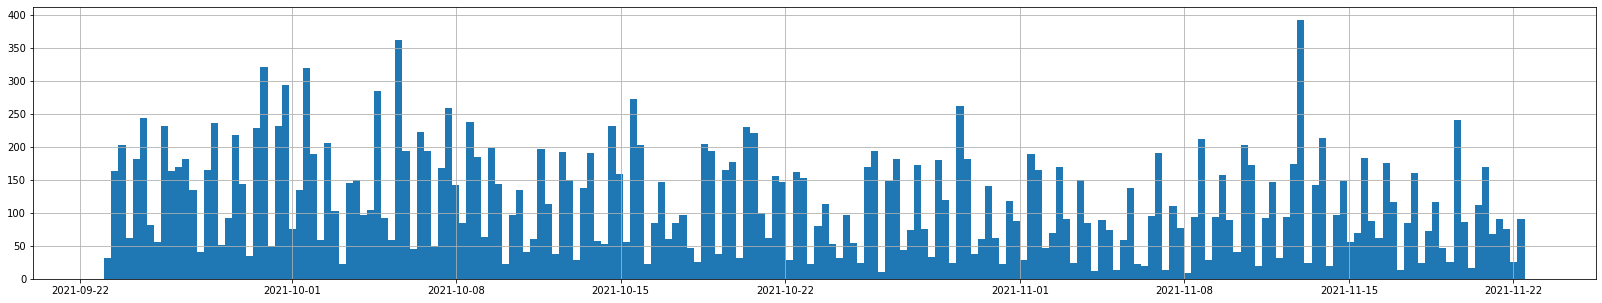

In [22]:
plt.figure(figsize=(28,5))
df_cr.crash_datetime.hist(bins=200)

Наложим число сессий на число крешей

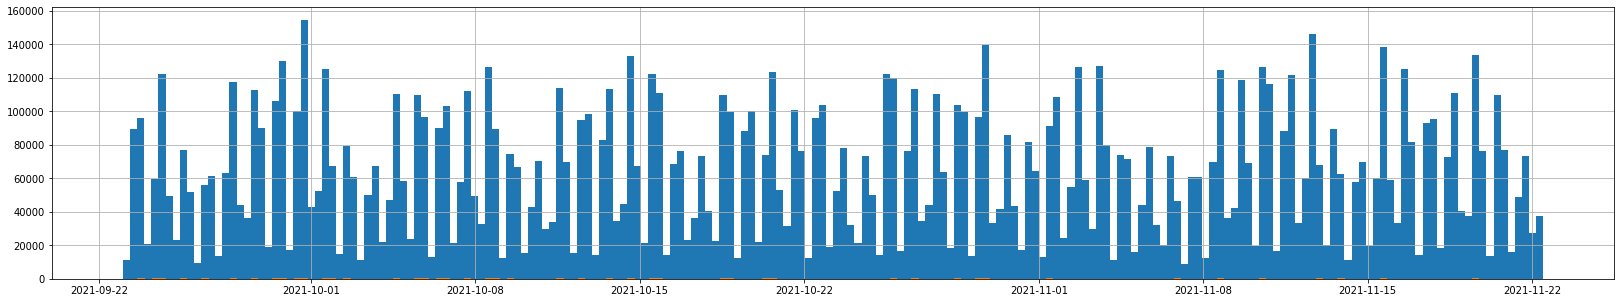

In [23]:
plt.figure(figsize=(28,5))
df_ses.session_start_datetime.hist(bins=200)
df_cr.crash_datetime.hist(bins=200)

Процент крешей относительно всех устройств в разрезе операционных систем

In [24]:
os_name = df_cr.os_name.value_counts()
print(os_name)
os_name / df_ses.os_name.value_counts() * 100

android    18990
ios         4412
Name: os_name, dtype: int64


android    0.194440
ios        0.145283
Name: os_name, dtype: float64

In [25]:
df_cr.groupby("os_name").crash_nano.value_counts()

os_name  crash_nano                                                   
android  java.lang.IllegalStateException                                  6933
         java.lang.RuntimeException                                       2657
         java.lang.NullPointerException                                   2418
         java.lang.IndexOutOfBoundsException                              2129
         android.database.sqlite.SQLiteFullException                      1443
         android.database.sqlite.SQLiteReadOnlyDatabaseException          1004
         java.lang.NoClassDefFoundError                                    786
         android.database.sqlite.SQLiteCantOpenDatabaseException           323
         java.lang.IllegalArgumentException                                214
         java.lang.OutOfMemoryError                                        208
         android.database.sqlite.SQLiteException                           195
         android.database.sqlite.SQLiteDiskIOException      

In [26]:
df_cr.groupby(["os_name", "crash_group_id"]).crash_nano.value_counts().sort_values(ascending=False)[:12]

os_name  crash_group_id        crash_nano                                             
ios      645289792956860606    Incident Identifier                                        3457
android  3315005516681935250   java.lang.IllegalStateException                            2805
         1258601548750548270   java.lang.IllegalStateException                            1418
         3105031379088657898   java.lang.IndexOutOfBoundsException                        1396
         9258278938929507823   java.lang.IllegalStateException                            1204
         9506317484047420985   java.lang.NullPointerException                             1189
         3178641433742095709   java.lang.IllegalStateException                             974
         113164558630065075    java.lang.RuntimeException                                  965
         4118277038243201716   android.database.sqlite.SQLiteFullException                 879
         5734070556593177522   android.database.sqlite.SQL

Процент всех крешей относительно всех устройств в разрезе производителей

In [60]:
device_manufacturer = df_cr.device_manufacturer.value_counts()
# print(device_manufacturer[:5])
device_manufacturer = device_manufacturer / df_ses.device_manufacturer.value_counts() * 100
device_manufacturer.sort_values(ascending=False)

Xgody         36.000000
Vobis         23.507463
Mate30        14.814815
Stark         11.764706
K4000 Plus     9.333333
                ...    
stack               NaN
teksun              NaN
vmos                NaN
welcome             NaN
wheatek             NaN
Name: device_manufacturer, Length: 292, dtype: float64

In [28]:
device_manufacturer.sort_values(ascending=False)[:15]

Xgody                  36.000000
Vobis                  23.507463
Mate30                 14.814815
Stark                  11.764706
K4000 Plus              9.333333
XDJA                    8.474576
HXY                     4.211663
MTK                     3.125000
Elite 1                 3.125000
Gtel                    2.835922
MOTNB                   2.688172
Zuk                     2.375566
Google                  2.368955
Billion                 2.352941
BullittGroupLimited     2.314815
Name: device_manufacturer, dtype: float64

In [29]:
df_cr.groupby("device_manufacturer").crash_nano.value_counts().sort_values(ascending=False)

device_manufacturer  crash_nano                                   
Apple                Incident Identifier                              4412
Samsung              java.lang.IllegalStateException                  2405
Huawei               java.lang.IllegalStateException                  1917
Samsung              android.database.sqlite.SQLiteFullException      1431
                     java.lang.RuntimeException                       1175
                                                                      ... 
LeTV                 android.database.sqlite.SQLiteDiskIOException       1
LeMobile             java.lang.RuntimeException                          1
                     java.lang.IndexOutOfBoundsException                 1
                     java.lang.IllegalArgumentException                  1
A-gold               java.lang.IllegalStateException                     1
Name: crash_nano, Length: 469, dtype: int64

Есть производители, у которых ошибок не было

In [30]:
device_manufacturer[device_manufacturer.isna()]

4G           NaN
4good        NaN
A1           NaN
AG Mobile    NaN
AGM Mobile   NaN
              ..
stack        NaN
teksun       NaN
vmos         NaN
welcome      NaN
wheatek      NaN
Name: device_manufacturer, Length: 184, dtype: float64

Смотрим, при каком типе соединения больше всего ошибок

In [61]:
connection_type = df_cr.connection_type.value_counts()
# print(connection_type)
connection_type / df_ses.connection_type.value_counts() * 100

cell       0.175723
wifi       0.199441
unknown    0.228102
Name: connection_type, dtype: float64

In [32]:
df_cr.groupby("connection_type").crash_nano.value_counts()#.sort_values(ascending=False)

connection_type  crash_nano                                                   
cell             java.lang.IllegalStateException                                  4762
                 Incident Identifier                                              4412
                 java.lang.RuntimeException                                       1433
                 java.lang.NullPointerException                                   1270
                 java.lang.IndexOutOfBoundsException                              1229
                                                                                  ... 
wifi             java.lang.ArithmeticException                                       3
                 java.lang.StringIndexOutOfBoundsException                           3
                 java.lang.VerifyError                                               3
                 android.os.BadParcelableException                                   1
                 com.android.internal.util.SyncResu

In [33]:
df_cr.groupby(["device_type", "os_name"]).crash_nano.value_counts()

device_type  os_name  crash_nano                                                   
phone        android  java.lang.IllegalStateException                                  6752
                      java.lang.RuntimeException                                       2647
                      java.lang.NullPointerException                                   2385
                      java.lang.IndexOutOfBoundsException                              2112
                      android.database.sqlite.SQLiteFullException                      1439
                      android.database.sqlite.SQLiteReadOnlyDatabaseException          1001
                      java.lang.NoClassDefFoundError                                    786
                      android.database.sqlite.SQLiteCantOpenDatabaseException           323
                      java.lang.OutOfMemoryError                                        208
                      android.database.sqlite.SQLiteException                           

# Свежие крэши (только за сегодня)

In [62]:
year, month, day = datetime.today().year, datetime.today().month, datetime.today().day
todaty_cr = df_cr[df_cr.crash_datetime > np.datetime64(f"{year:0>4}-{month:0>2}-{day:0>2} 00:00:00")]
print(f"Ошибок с начала дня {todaty_cr.shape[0]}")

Ошибок с начала дня 92


Распределение ошибок по времени суток

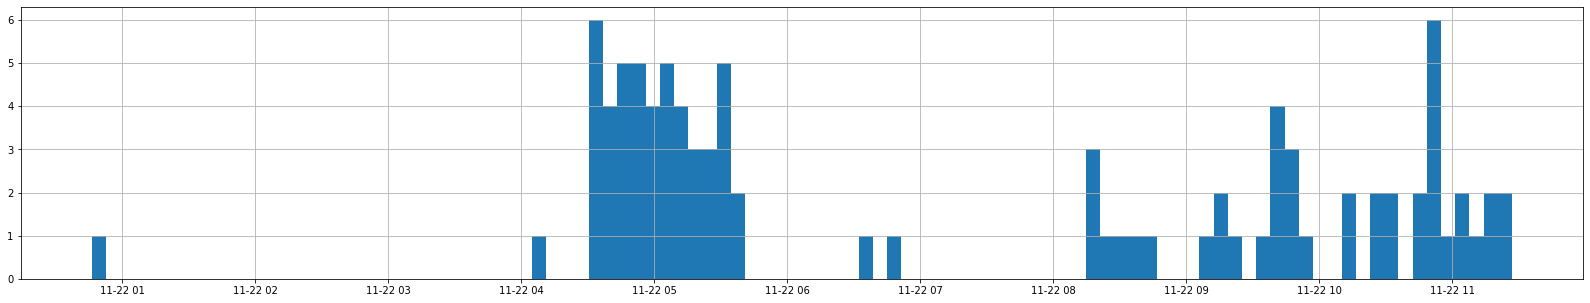

In [35]:
plt.figure(figsize=(28,5))
todaty_cr.crash_datetime.hist(bins=100)

Колонки, которые можно использовать для анализа

In [36]:
todaty_cr.columns

Index(['mnc', 'crash_receive_timestamp', 'connection_type', 'app_version_name',
       'operator_name', 'crash_group_id', 'os_name', 'appmetrica_device_id',
       'city', 'mcc', 'device_manufacturer', 'crash', 'android_id', 'crash_id',
       'crash_receive_datetime', 'country_iso_code', 'crash_timestamp',
       'os_version', 'device_type', 'device_locale', 'device_model',
       'app_package_name', 'crash_datetime', 'crash_nano', 'crash_mini'],
      dtype='object')

Распределение ошибок по операционным системам

In [37]:
todaty_cr.os_name.value_counts()

android    91
ios         1
Name: os_name, dtype: int64

Распределение ошибок по локализации

In [38]:
todaty_cr.device_locale.value_counts()

ru_RU         91
en_US          1
zh_CN          0
ru_CN          0
de_DE          0
en             0
en_CA          0
en_CH          0
en_GB          0
en_RU          0
en_UA          0
en_WS          0
ru_AI          0
ru_AT          0
ru_AX          0
ru_BY          0
ru_DE          0
zh-Hans_CN     0
ru_ES          0
ru_FR          0
ru_GB          0
ru_ID          0
ru_IL          0
ru_IN          0
ru_IT          0
ru_KZ          0
ru_SG          0
ru_UA          0
ru_US          0
uk_RU          0
cs_CZ          0
Name: device_locale, dtype: int64

Распределение ошибок по версии нашего приложения

In [39]:
todaty_cr.app_version_name.value_counts()

5.12.6          54
5.13.4          23
5.12.5           4
5.13.0           2
5.13.1           2
5.12.4           2
5.13.3           2
5.8.0            1
5.13.4.debug     1
5.6.13           1
5.13.1.debug     0
5.13.0.debug     0
5.12.5.debug     0
5.12.8.debug     0
5.12.4.debug     0
5.12.3           0
5.12.2           0
5.12.0           0
5.10.0           0
5.13.2           0
5.9.0            0
5.13.3.debug     0
5.6.4            0
5.7.1            0
5.7.0            0
5.6.9            0
5.6.8            0
5.6.7            0
5.6.6            0
5.6.16.debug     0
5.8.1            0
5.6.16           0
5.6.15           0
5.6.14           0
5.6.12           0
5.6.11           0
5.17.0.debug     0
0.0              0
Name: app_version_name, dtype: int64

Распределение ошибок по типу интернет соединения

In [40]:
todaty_cr.connection_type.value_counts()

wifi       55
cell       37
unknown     0
Name: connection_type, dtype: int64

Распределение ошибок по производителям. Но это не очень показательно, так как те у кого больше всего ошибок, тех и просто больше. У огромноо количества наших пользователей самсунги

In [41]:
todaty_cr.device_manufacturer.value_counts()

Samsung    66
Huawei     12
Sony        2
Asus        2
Alcatel     1
           ..
Redmi       0
SGINO       0
Senseit     0
Sharp       0
A-gold      0
Name: device_manufacturer, Length: 108, dtype: int64

Распределение ошибок по операционным системам и их версиям

In [42]:
todaty_cr.groupby("os_name").os_version.value_counts()

os_name  os_version
android  5.0           52
         10             8
         5.0.2          6
         7.0            4
         9              4
         5.1.1          3
         8.0.0          3
         11             2
         5.1            2
         6.0.1          2
         8.1.0          2
         5.0.1          1
         6.0            1
         7.1.1          1
ios      14.8.1         1
Name: os_version, dtype: int64

Распределение ошибок по операционным системам и группам ошибок. Что значят эти группы не знаю. Можно попробовать разрабов поспрашивать

In [43]:
todaty_cr.groupby(["os_name", "crash_group_id"]).crash_nano.value_counts()

os_name  crash_group_id        crash_nano                                             
android  1258601548750548270   java.lang.IllegalStateException                             7
         2401028957874188318   java.lang.NullPointerException                             51
         3178641433742095709   java.lang.IllegalStateException                             1
         3315005516681935250   java.lang.IllegalStateException                             2
         3429376732815470453   android.database.sqlite.SQLiteCantOpenDatabaseException     2
         4153168319403723906   java.lang.IllegalStateException                             1
         4904766931511575991   java.lang.RuntimeException                                  1
         6905241937823323471   java.lang.IndexOutOfBoundsException                         2
         7228057208072563285   java.lang.NullPointerException                              2
         7281349877587536186   android.database.sqlite.SQLiteReadOnlyDatabas

Распределение ошибок по версиям операционных систем

In [59]:
todaty_cr.groupby(["os_version", "crash_nano"]).mnc.count().sort_values(ascending=False)[:26]

os_version  crash_nano                                             
5.0         java.lang.NullPointerException                             51
5.0.2       java.lang.IllegalStateException                             6
10          java.lang.IllegalStateException                             4
8.0.0       java.lang.IllegalStateException                             3
5.1.1       android.database.sqlite.SQLiteCantOpenDatabaseException     3
10          java.lang.IndexOutOfBoundsException                         3
9           java.lang.IllegalStateException                             3
7.0         java.lang.IllegalStateException                             2
            java.lang.RuntimeException                                  1
6.0.1       android.database.sqlite.SQLiteReadOnlyDatabaseException     1
11          java.lang.IndexOutOfBoundsException                         1
            java.lang.IllegalStateException                             1
6.0.1       java.lang.RuntimeException      

Исключаем самую частую ошибку "java.lang.NullPointerException" и смотрим на остальные в менее обрезанном формате




In [46]:
todaty_cr[todaty_cr.crash_nano != "java.lang.NullPointerException"].groupby(["os_name", "crash_group_id"]).crash_mini.value_counts()

os_name  crash_group_id        crash_mini                                                                                                                                                                                                                                                                                                      
android  1258601548750548270   java.lang.IllegalStateException: Unable to create layer for LottieAnimationView                                                                                                                                                                                                                                      7
         3178641433742095709   java.lang.IllegalStateException: Can not perform this action after onSaveInstanceState                                                                                                                                                                                                             

Смотрим на самую распространенную ошибку отдельно. Видим три подгруппы ошибок и их частоты

In [47]:
todaty_cr[todaty_cr.crash_nano == "java.lang.NullPointerException"].groupby(["os_name", "crash_group_id"]).crash_mini.value_counts()

os_name  crash_group_id        crash_mini                                                                                                                                         
android  2401028957874188318   java.lang.NullPointerException: Attempt to read from field 'int com.android.server.LocationManagerService$Receiver.mUid' on a null object reference    51
         7228057208072563285   java.lang.NullPointerException: Attempt to invoke virtual method 'java.lang.Object java.lang.ref.WeakReference.get()' on a null object reference        2
         12719663074503264273  java.lang.NullPointerException: Attempt to invoke virtual method 'void android.view.View.setBackgroundColor(int)' on a null object reference            1
Name: crash_mini, dtype: int64

Полные тексты ошибок

In [48]:
todaty_cr[todaty_cr.crash_nano == "java.lang.NullPointerException"].groupby(["os_name", "crash_group_id"]).crash.value_counts()

os_name  crash_group_id        crash                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    